Enter the number of rows in the grid: 5
Enter the number of columns in the grid: 5
Enter the grid layout row by row in the format: 'A', 'X', '.', 'B'
Use:
'A' for starting positions of bots.
'X' for obstacles.
'.' for empty spaces.
'B' for goal positions.
Row 1: A X . X B
Row 2: . X . . .
Row 3: . . X X .
Row 4: . . . . .
Row 5: A X . . B
Resolved deadlock by moving bot 0 to (3, 0)
Resolved deadlock by moving bot 0 to (3, 0)
Resolved deadlock by moving bot 0 to (3, 0)
Resolved deadlock by moving bot 1 to (3, 3)
Resolved deadlock by moving bot 1 to (3, 3)
Resolved deadlock by moving bot 0 to (3, 0)
Resolved deadlock by moving bot 1 to (3, 3)
Resolved deadlock by moving bot 0 to (3, 0)
Resolved deadlock by moving bot 1 to (3, 3)
Resolved deadlock by moving bot 1 to (3, 3)
Resolved deadlock by moving bot 1 to (3, 3)
Resolved deadlock by moving bot 0 to (3, 0)
Resolved deadlock by moving bot 0 to (3, 0)
Resolved deadlock by moving bot 1 to (3, 3)
Resolved deadlock by moving bot 1 to (3, 3)

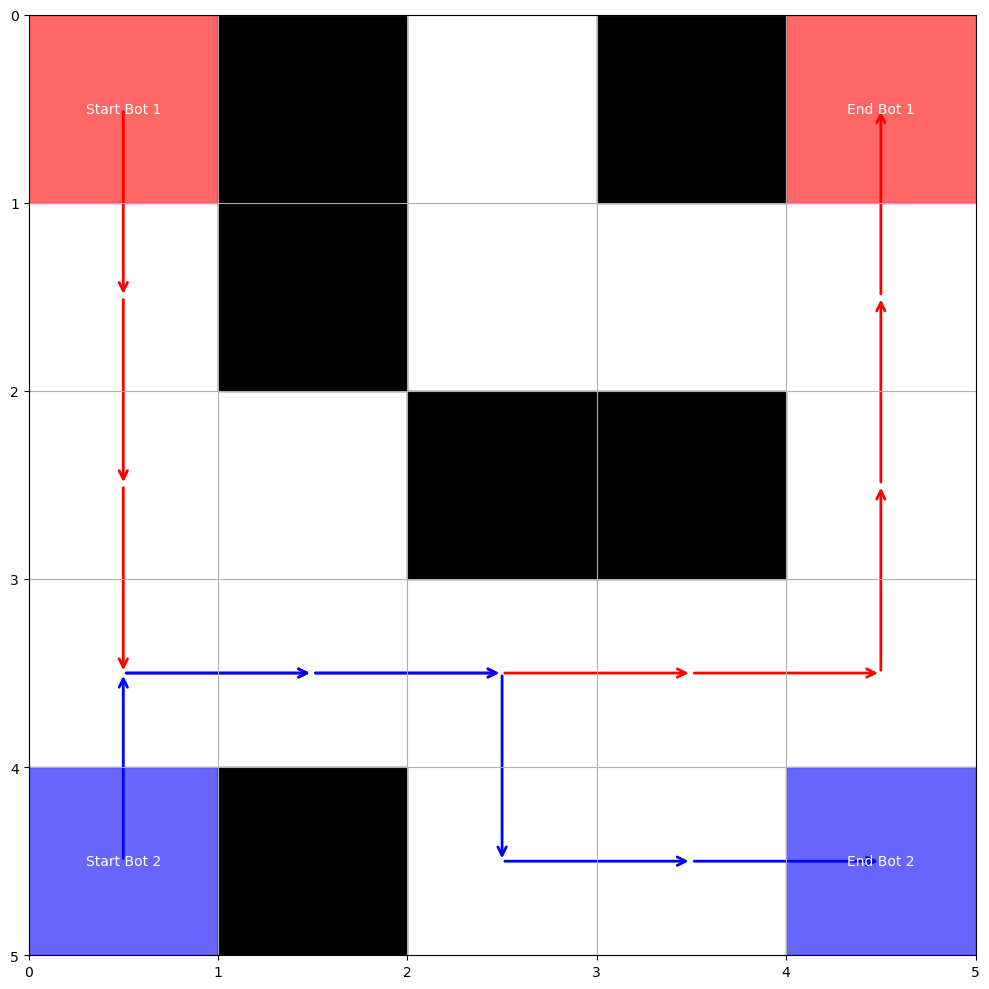

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import random
from collections import defaultdict
import time

class WarehouseEnv:
    def __init__(self, grid):
        self.grid = np.array(grid)
        self.rows, self.cols = self.grid.shape
        self.autobots = []
        self.goals = []
        for r in range(self.rows):
            for c in range(self.cols):
                if self.grid[r, c] == 'A':
                    self.autobots.append((r, c, 0))  # (row, col, direction)
                elif self.grid[r, c] == 'B':
                    self.goals.append((r, c))
        self.initial_positions = self.autobots.copy()
        self.deadlock_counter = 0
        self.max_deadlock = 10  # Maximum number of consecutive deadlocks before resolution

    def is_valid(self, pos):
        r, c = pos
        return 0 <= r < self.rows and 0 <= c < self.cols and self.grid[r, c] != 'X'

    def move(self, pos, action):
        r, c, d = pos
        if action == 0:  # Forward
            if d == 0: r -= 1
            elif d == 1: c += 1
            elif d == 2: r += 1
            else: c -= 1
        elif action == 1:  # Reverse
            if d == 0: r += 1
            elif d == 1: c -= 1
            elif d == 2: r -= 1
            else: c += 1
        elif action == 2:  # Turn Left
            d = (d - 1) % 4
        elif action == 3:  # Turn Right
            d = (d + 1) % 4
        elif action == 4:  # Wait
            pass  # Stay in place
        return (r, c, d)

    def find_alternative_path(self, current_pos, goal_pos):
        # Simple BFS to find an alternative path
        queue = [(current_pos, [])]
        visited = set()

        while queue:
            (r, c, d), path = queue.pop(0)
            if (r, c) == goal_pos:
                return path

            if (r, c) in visited:
                continue
            visited.add((r, c))

            for action in range(5):  # 5 possible actions
                new_pos = self.move((r, c, d), action)
                if self.is_valid(new_pos[:2]):
                    queue.append((new_pos, path + [action]))

        return None  # No path found

    def resolve_deadlock(self):
        # Randomly choose a bot to move to a neighboring empty cell
        available_bots = list(range(len(self.autobots)))
        random.shuffle(available_bots)

        for bot_index in available_bots:
            r, c, d = self.autobots[bot_index]
            for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                new_r, new_c = r + dr, c + dc
                if self.is_valid((new_r, new_c)) and (new_r, new_c) not in [bot[:2] for bot in self.autobots]:
                    self.autobots[bot_index] = (new_r, new_c, d)
                    print(f"Resolved deadlock by moving bot {bot_index} to ({new_r}, {new_c})")
                    return True
        return False

    def step(self, actions):
        rewards = [0] * len(self.autobots)
        new_positions = []
        proposed_positions = []

        for i, (action, autobot) in enumerate(zip(actions, self.autobots)):
            new_pos = self.move(autobot, action)
            if self.is_valid(new_pos[:2]):
                proposed_positions.append(new_pos)
            else:
                proposed_positions.append(autobot)

        position_count = defaultdict(int)
        for pos in proposed_positions:
            position_count[pos[:2]] += 1

        all_stayed_in_place = True

        for i, new_pos in enumerate(proposed_positions):
            if position_count[new_pos[:2]] > 1:
                # Collision detected, find an alternative path
                alternative_path = self.find_alternative_path(self.autobots[i], self.goals[i])
                if alternative_path:
                    # Take the first step of the alternative path
                    new_pos = self.move(self.autobots[i], alternative_path[0])
                    rewards[i] = -5  # Small penalty for taking alternative path
                else:
                    new_pos = self.autobots[i]
                    rewards[i] = -10  # Larger penalty if no alternative path found
            else:
                rewards[i] = -1  # Small penalty for each move

            if new_pos[:2] == self.goals[i]:
                rewards[i] = 100  # Reward for reaching goal

            new_positions.append(new_pos)
            if new_pos != self.autobots[i]:
                all_stayed_in_place = False

        if all_stayed_in_place:
            self.deadlock_counter += 1
            if self.deadlock_counter >= self.max_deadlock:
                if self.resolve_deadlock():
                    self.deadlock_counter = 0
                else:
                    print("Unable to resolve deadlock")
        else:
            self.deadlock_counter = 0

        self.autobots = new_positions
        done = all(autobot[:2] == goal for autobot, goal in zip(self.autobots, self.goals))
        return rewards, done

    def reset(self):
        self.autobots = self.initial_positions.copy()
        self.deadlock_counter = 0

# ... [Rest of the code remains the same] ...
class QLearningAgent:
    def __init__(self, action_size, learning_rate=0.1, discount_factor=0.95, epsilon=0.1):
        self.q_table = defaultdict(lambda: np.zeros(action_size))
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.action_size = action_size

    def get_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state):
        current_q = self.q_table[state][action]
        next_max_q = np.max(self.q_table[next_state])
        new_q = current_q + self.lr * (reward + self.gamma * next_max_q - current_q)
        self.q_table[state][action] = new_q

def train(env, agents, episodes=1000, max_steps=1000):
    best_episode_steps = float('inf')
    best_episode_paths = None
    best_episode_actions = None
    time_taken = []
    command_stats = []
    impossible = True
    impossible_detection_step = 0

    for episode in range(episodes):
        env.reset()
        done = False
        steps = 0
        start_time = time.time()

        paths = [[autobot[:2]] for autobot in env.autobots]
        episode_actions = [[] for _ in range(len(env.autobots))]
        episode_command_count = [0] * len(env.autobots)

        while not done and steps < max_steps:
            states = [tuple(autobot) for autobot in env.autobots]
            actions = [agent.get_action(state) for agent, state in zip(agents, states)]
            rewards, done = env.step(actions)

            for i, (autobot, action) in enumerate(zip(env.autobots, actions)):
                # Only append to the path if the bot hasn't reached its goal
                if paths[i][-1] != env.goals[i]:
                    paths[i].append(autobot[:2])
                episode_actions[i].append(action)
                agents[i].update(states[i], action, rewards[i], tuple(autobot))
                episode_command_count[i] += 1

            steps += 1

        end_time = time.time()
        time_taken.append((episode, steps, end_time - start_time))
        command_stats.append((episode, episode_command_count))

        if done and steps < best_episode_steps:
            best_episode_steps = steps
            best_episode_paths = paths
            best_episode_actions = episode_actions
            impossible = False
        
        if steps == max_steps and impossible:
            impossible_detection_step = max(impossible_detection_step, max(episode_command_count))

        # Decay epsilon
        for agent in agents:
            agent.epsilon = max(0.01, agent.epsilon * 0.995)

    return best_episode_paths, best_episode_actions, time_taken, impossible, command_stats, impossible_detection_step

def visualize_path_with_arrows(env, paths, actions):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, env.cols)
    ax.set_ylim(0, env.rows)
    ax.invert_yaxis()

    path_colors = ['red', 'blue', 'green', 'orange', 'purple']

    for r in range(env.rows):
        for c in range(env.cols):
            if env.grid[r, c] == 'X':
                ax.add_patch(Rectangle((c, r), 1, 1, color='black'))
            elif env.grid[r, c] == 'A':
                for i, path in enumerate(paths):
                    if (r, c) == path[0]:
                        ax.add_patch(Rectangle((c, r), 1, 1, color=path_colors[i % len(path_colors)], alpha=0.6))
                        ax.text(c + 0.5, r + 0.5, f'Start Bot {i+1}', color='white', ha='center', va='center')
            elif env.grid[r, c] == 'B':
                for i, path in enumerate(paths):
                    if (r, c) == path[-1]:
                        ax.add_patch(Rectangle((c, r), 1, 1, color=path_colors[i % len(path_colors)], alpha=0.6))
                        ax.text(c + 0.5, r + 0.5, f'End Bot {i+1}', color='white', ha='center', va='center')

    for i, (path, bot_actions) in enumerate(zip(paths, actions)):
        color = path_colors[i % len(path_colors)]
        action_index = 0
        for j in range(len(path) - 1):
            start = path[j]
            end = path[j + 1]
            if start == end:
                if action_index < len(bot_actions) and bot_actions[action_index] == 4:  # Wait action
                    ax.text(start[1] + 0.5, start[0] + 0.5, 'Wait', color='purple', ha='center', va='center', fontsize=8)
                    action_index += 1
            else:
                ax.add_patch(FancyArrowPatch((start[1] + 0.5, start[0] + 0.5), (end[1] + 0.5, end[0] + 0.5), 
                                             color=color, arrowstyle='->', mutation_scale=15, lw=2))
                action_index += 1

    plt.grid(True)
    plt.tight_layout()
    plt.show()

def get_dynamic_grid_input():
    while True:
        try:
            rows = int(input("Enter the number of rows in the grid: "))
            cols = int(input("Enter the number of columns in the grid: "))
            if rows <= 0 or cols <= 0:
                raise ValueError("Rows and columns must be positive integers.")
            break
        except ValueError as e:
            print(f"Invalid input: {e}. Please try again.")

    print("Enter the grid layout row by row in the format: 'A', 'X', '.', 'B'")
    print("Use:")
    print("'A' for starting positions of bots.")
    print("'X' for obstacles.")
    print("'.' for empty spaces.")
    print("'B' for goal positions.")

    grid = []
    for r in range(rows):
        while True:
            row_input = input(f"Row {r + 1}: ")
            row = row_input.split()
            if len(row) != cols:
                print(f"Invalid row length. Please enter exactly {cols} elements.")
                continue
            if all(cell in {'A', 'X', '.', 'B'} for cell in row):
                grid.append(row)
                break
            else:
                print(f"Invalid characters in row. Use only 'A', 'X', '.', 'B'.")
    
    return grid

def action_to_name(action):
    action_names = ['Forward', 'Reverse', 'Turn Left', 'Turn Right', 'Wait']
    return action_names[action]

if __name__ == "__main__":
    grid = get_dynamic_grid_input()
    env = WarehouseEnv(grid)
    agents = [QLearningAgent(action_size=5) for _ in range(len(env.autobots))]
    best_paths, best_actions, time_taken, impossible, command_stats, impossible_detection_step = train(env, agents)

    if impossible:
        print("No solution found within the given constraints.")
        print(f"Scenario identified as impossible after {impossible_detection_step} commands.")
    else:
        print("Best solution found:")
        for idx, path in enumerate(best_paths):
            print(f"Path for Autobot {idx+1}: {path}")
        
        print("\nActions taken per autobot for the best path:")
        for idx, actions in enumerate(best_actions):
            print(f"Autobot {idx+1}: {[action_to_name(action) for action in actions]}")
        
        print(f"\nTotal number of movements/commands per autobot:")
        total_commands = [len(actions) for actions in best_actions]
        for idx, commands in enumerate(total_commands):
            print(f"Autobot {idx+1}: {commands} commands")
        
        average_commands = sum(total_commands) / len(total_commands)
        print(f"\nAverage number of commands: {average_commands:.2f}")
        
        max_commands = max(total_commands)
        print(f"Maximum number of commands (determines when the test case finishes): {max_commands}")

        print("\nEpisode stats (time taken):")
        for episode, steps, duration in time_taken:
            print(f"Episode {episode}: Steps = {steps}, Duration = {duration:.4f} seconds")

        print("\nCommand count per Autobot per episode:")
        for episode, command_count in command_stats:
            print(f"Episode {episode}: {command_count}")

        visualize_path_with_arrows(env, best_paths, best_actions)